In [2]:
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.17.0'

### Loading the data



###### Hourly electric power load values from the 33/11 KV substation in Godishala, Telangana, for 2021, including voltage, current, power factor, temperature, and humidity. The data features historical averages to fill 66 missing entries, reflecting load distribution across weekdays and weekends.

In [8]:
df = pd.read_excel("C:\\Users\\Ramte\\Documents\\4th year\\new\\Active Power Load - 33_11KV - Godishala Substation .xlsx")
data=df['POWER (KW)']

In [9]:
data.head()

0    1967.388015
1    1967.388015
2    1967.388015
3    2442.607331
4    2756.205522
Name: POWER (KW), dtype: float64

In [10]:
data = data.to_frame()

In [11]:
data.head()

,POWER (KW)
0,1967.388015
1,1967.388015
2,1967.388015
3,2442.607331
4,2756.205522


In [12]:
type(df)

pandas.core.frame.DataFrame

### Scaling the data

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
data1 = scaler.fit_transform(data)

### Plotting the original Data

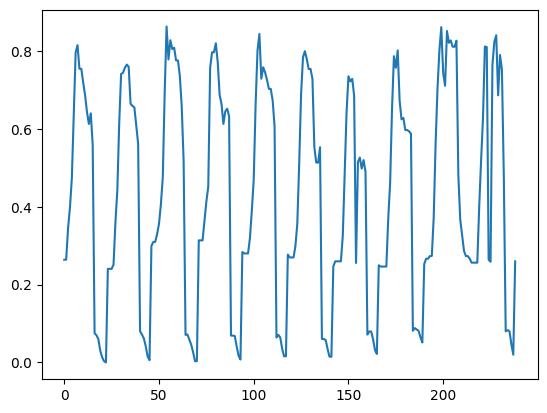

In [13]:
plt.plot(data1[1:10*24])

In [14]:
def create_input_output_pairs(data, window_length=30 * 24 , prediction_length=24, step_size=24 ):
    num_samples = (len(data) - window_length - prediction_length) // step_size + 1
    X = np.array([data[i:i + window_length] for i in range(0, num_samples * step_size, step_size)])
    y = np.array([data[i + window_length:i + window_length + prediction_length] for i in range(0, num_samples * step_size, step_size)])
    return X, y

# Create input-output pairs
X, y = create_input_output_pairs(data1)

### Diving the data into train and test

In [15]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your feature and target arrays respectively
# Scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [16]:
print(X.shape)
y.shape

(335, 720, 1)


(335, 24, 1)

In [17]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers    import Dense,Conv1D, MaxPooling1D, LSTM,Flatten, Dropout 
from keras.callbacks import EarlyStopping, ModelCheckpoint

 ### Model Architecture and Implementation
The proposed model utilises a hybrid CNN-LSTM architecture, where the convolutional layers extract spatial features from the input time series data, followed by LSTM layers that capture temporal dependencies. This design enhances the model's ability to accurately forecast electrical load over short-term intervals.

In [18]:

# Model definition with LSTM
# Build a CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30*24, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(24))
model.compile(optimizer='adam', loss='mean_squared_error')


# Define the checkpoint to save the model during training
checkpoint_filepath = 'model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Set to False to save the entire model (architecture + weights)
    monitor='loss',           # Monitors the training loss
    mode='min',               # Save the model with the lowest loss
    save_best_only=True)       # Only save the model if the loss improves

# Train the model and save the best version
model.fit(X, y, epochs=20, batch_size=32, callbacks=[model_checkpoint_callback])

# Save the final trained model (optional if you want to save after training)
model.save('ram_2.keras')


C:\Users\Ramte\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.1091
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0286
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0126
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0102
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0088
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0094
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0105
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0094
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0092
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0083
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0082
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0091
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0082
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0084
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - lo

In [19]:
model.evaluate(X_test,y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0084 


0.007501114625483751

In [20]:
y_pred=model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [21]:
y_pred1=model.predict(X_train)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [22]:
y_train = np.squeeze(y_train)  # Remove the extra dimension
y_test = np.squeeze(y_test)    # Remove the extra dimension

In [23]:

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train = mean_absolute_percentage_error(y_train, y_pred1)
mape_test = mean_absolute_percentage_error(y_test, y_pred)

# Print MAPE
print("Training Set MAPE:", mape_train, "%")
print("Test Set MAPE:", mape_test, "%")

Training Set MAPE: 33.2094668609019 %
Test Set MAPE: 30.924176995945587 %


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae_train = mean_absolute_error(y_train, y_pred1)
mae_test = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred1))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2_train = r2_score(y_train, y_pred1)
r2_test = r2_score(y_test, y_pred)

# Print all metrics
print("Training Set MAE:", mae_train)
print("Test Set MAE:", mae_test)
print("Training Set RMSE:", rmse_train)
print("Test Set RMSE:", rmse_test)
print("Training Set R²:", r2_train)
print("Test Set R²:", r2_test)

Training Set MAE: 0.060525275837832654
Test Set MAE: 0.053353914588987805
Training Set RMSE: 0.09261747530797013
Test Set RMSE: 0.08660897217719109
Training Set R²: 0.5187332928056224
Test Set R²: 0.5627655845481582


### Performance on Training data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_34760\1372667498.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


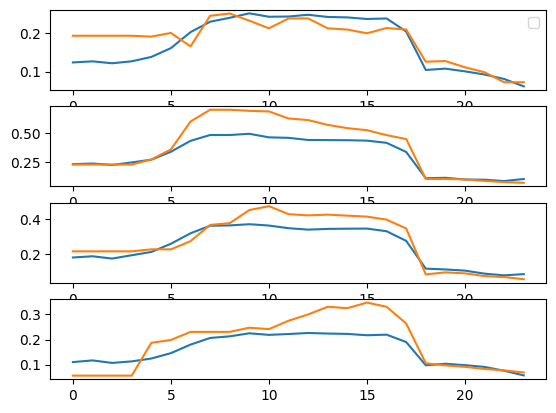

In [25]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred1[7])
axs[0].plot(y_train[7])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred1[10])
axs[1].plot(y_train[10])

axs[2].plot(y_pred1[15])
axs[2].plot(y_train[15])

axs[3].plot(y_pred1[30])
axs[3].plot(y_train[30])

### Performance on test Data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_34760\3820575154.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


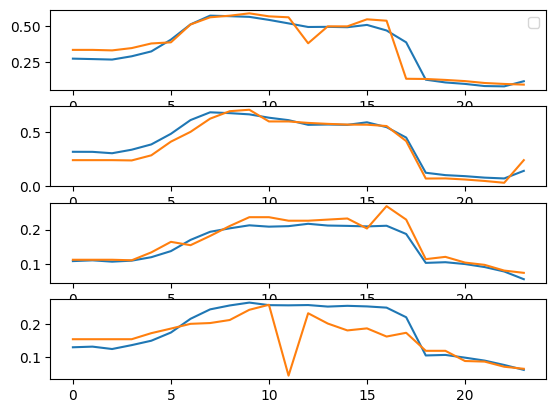

In [26]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred[7])
axs[0].plot(y_test[7])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred[10])
axs[1].plot(y_test[10])

axs[2].plot(y_pred[15])
axs[2].plot(y_test[15])

axs[3].plot(y_pred[30])
axs[3].plot(y_test[30])

### Retraining Model

In [28]:
from keras.models import load_model
model = load_model("ram_2.keras")

In [29]:
# Define the checkpoint to save the model during retraining
checkpoint_filepath = 'model_checkpoint_retrain.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True
)

# Continue training the model for more epochs
model.fit(X, y, 
          epochs=100,  # Specify how many more epochs to train
          batch_size=32, 
          callbacks=[model_checkpoint_callback])

# Optionally save the final retrained model
model.save('ram_2_retrained.keras')

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0075
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0092
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0097
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0077
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0084
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0074
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0082
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0073
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0079
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0079
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0088
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0081
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0082
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0079
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [30]:
model.evaluate(X_test,y_test)
y_pred=model.predict(X_test)
y_pred1=model.predict(X_train)
y_train = np.squeeze(y_train)  # Remove the extra dimension
y_test = np.squeeze(y_test)    # Remove the extra dimension
mape_train = mean_absolute_percentage_error(y_train, y_pred1)
mape_test = mean_absolute_percentage_error(y_test, y_pred)

# Print MAPE
print("Training Set MAPE:", mape_train, "%")
print("Test Set MAPE:", mape_test, "%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0061
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Training Set MAPE: 29.14818248370089 %
Test Set MAPE: 27.79758998542004 %


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae_train = mean_absolute_error(y_train, y_pred1)
mae_test = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred1))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2_train = r2_score(y_train, y_pred1)
r2_test = r2_score(y_test, y_pred)

# Print all metrics
print("Training Set MAE:", mae_train)
print("Test Set MAE:", mae_test)
print("Training Set RMSE:", rmse_train)
print("Test Set RMSE:", rmse_test)
print("Training Set R²:", r2_train)
print("Test Set R²:", r2_test)

Training Set MAE: 0.047320957910453425
Test Set MAE: 0.044236457683616566
Training Set RMSE: 0.07481428781611414
Test Set RMSE: 0.07339729244956336
Training Set R²: 0.651131446889681
Test Set R²: 0.6232335329419968


#### Performance on train Data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_34760\1372667498.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


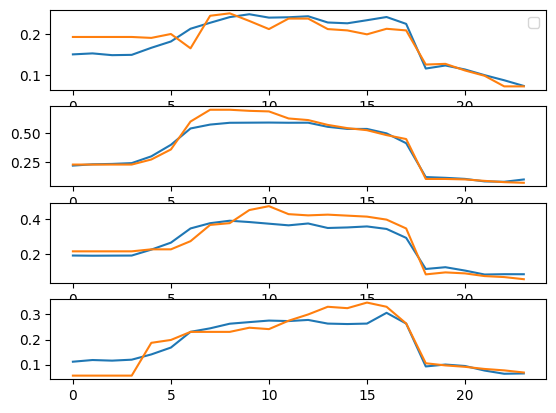

In [32]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred1[7])
axs[0].plot(y_train[7])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred1[10])
axs[1].plot(y_train[10])

axs[2].plot(y_pred1[15])
axs[2].plot(y_train[15])

axs[3].plot(y_pred1[30])
axs[3].plot(y_train[30])

#### Performance on test Data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_34760\3820575154.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


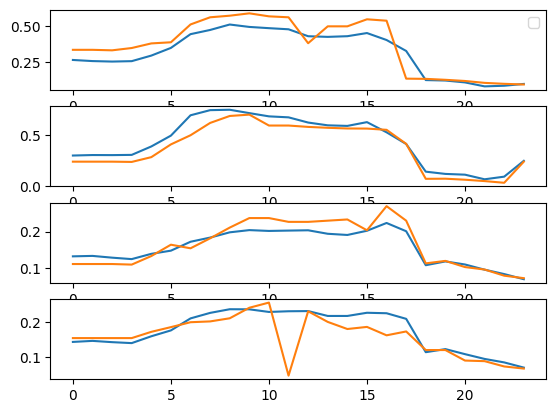

In [ ]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred[7])
axs[0].plot(y_test[7])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred[10])
axs[1].plot(y_test[10])

axs[2].plot(y_pred[15])
axs[2].plot(y_test[15])

axs[3].plot(y_pred[30])
axs[3].plot(y_test[30])

### Retrained_2 model

In [36]:
from keras.models import load_model
model = load_model('ram_2_retrained.keras')

In [37]:
# Define the checkpoint to save the model during retraining
checkpoint_filepath = 'model_checkpoint_retrain2.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True
)

# Continue training the model for more epochs
model.fit(X, y, 
          epochs=500,  # Specify how many more epochs to train
          batch_size=32, 
          callbacks=[model_checkpoint_callback])

# Optionally save the final retrained model
model.save('ram_2_retrained2.keras')

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0053
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0057
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0056
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0057
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0053
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 0.0051
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0068
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0061
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0055
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0059
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0053
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0051
Epoch 13/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0059
Epoch 14/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0057
Epoch 15/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 

#### Model performance

In [42]:
model.evaluate(X_test,y_test)
y_pred=model.predict(X_test)
y_pred1=model.predict(X_train)
y_train = np.squeeze(y_train)  # Remove the extra dimension
y_test = np.squeeze(y_test)    # Remove the extra dimension
mape_train = mean_absolute_percentage_error(y_train, y_pred1)
mape_test = mean_absolute_percentage_error(y_test, y_pred)

# Print MAPE
print("Training Set MAPE:", mape_train, "%")
print("Test Set MAPE:", mape_test, "%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0061
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Training Set MAPE: 27.825213540208537 %
Test Set MAPE: 27.038090725212495 %


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae_train = mean_absolute_error(y_train, y_pred1)
mae_test = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred1))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2_train = r2_score(y_train, y_pred1)
r2_test = r2_score(y_test, y_pred)

# Print all metrics
print("Training Set MAE:", mae_train)
print("Test Set MAE:", mae_test)
print("Training Set RMSE:", rmse_train)
print("Test Set RMSE:", rmse_test)
print("Training Set R²:", r2_train)
print("Test Set R²:", r2_test)

Training Set MAE: 0.04593316717572427
Test Set MAE: 0.043850232258340026
Training Set RMSE: 0.07124941611202702
Test Set RMSE: 0.07268046047659464
Training Set R²: 0.6757603374789958
Test Set R²: 0.6275035080297119


#### Model Perfromance On training data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_34760\2793029035.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


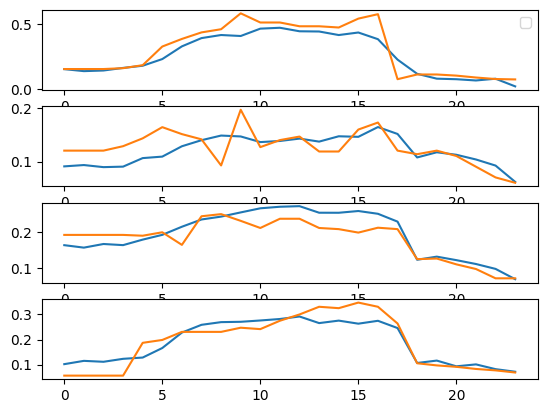

In [39]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred1[45])
axs[0].plot(y_train[45])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred1[5])
axs[1].plot(y_train[5])

axs[2].plot(y_pred1[7])
axs[2].plot(y_train[7])

axs[3].plot(y_pred1[30])
axs[3].plot(y_train[30])

#### Model Perfromance on Test Data

C:\Users\Ramte\AppData\Local\Temp\ipykernel_34760\2790547072.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')


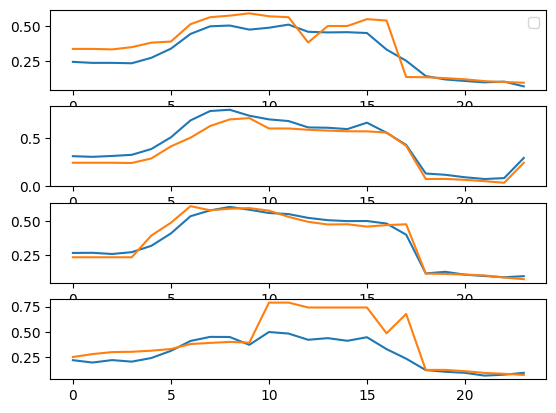

In [40]:
fig, axs = plt.subplots(4,1) 

axs[0].plot(y_pred[7])
axs[0].plot(y_test[7])
axs[0].legend(loc='upper right')
# Add labels and title

axs[1].plot(y_pred[10])
axs[1].plot(y_test[10])

axs[2].plot(y_pred[45])
axs[2].plot(y_test[45])

axs[3].plot(y_pred[12])
axs[3].plot(y_test[12])